# Deep learning NER

In this notebook, we will discover two deep learning techniques for Named Entity Recognition (or NER).

- LSTM (Long Short Term Memory)
- Transformers


The generated **BIO** file by the script will be loaded as well as a corpus of lambda sentences that don't necessarily contain either an _arrival_ or _departure_ location.

Since the goal is to extract the locations from a user's query, the times in which random sentences might be inputted should be accounted for. Therefore, to stay rational with the frequency of that happening, the ratio will be $1:10$ for the lambda sentences which will be extracted from `data/french_text/1k_unlabeled_samples.txt`.


In [3]:
from app.travel_resolver.libs.nlp import data_processing as dp

sentences, labels, vocab, unique_labels = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/10k_samples.bio"
)

[nltk_data] Downloading package punkt_tab to /Users/az-r-
[nltk_data]     ow/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
lambda_sentences, lambda_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/1k_unlabeled_samples.bio"
)

In [5]:
sentences = sentences + lambda_sentences
labels = labels + lambda_labels

In [6]:
processed_sentences = []
processed_labels = []

for sentence, label in zip(sentences, labels):
    sentence, label = dp.process_sentence(
        sentence, stemming=True, return_tokens=True, labels_to_adapt=label
    )
    processed_sentences.append(sentence)
    processed_labels.append(label)

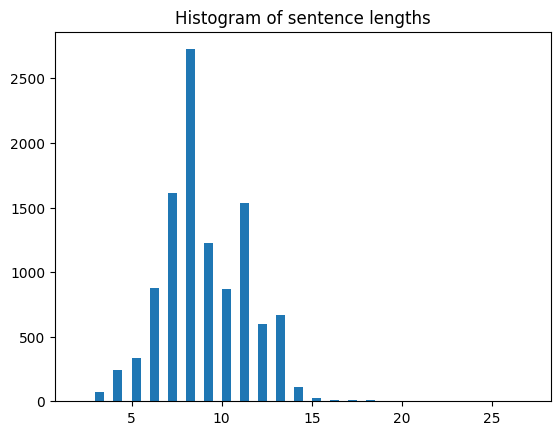

In [7]:
import matplotlib.pyplot as plt

plt.hist([len(sentence) for sentence in processed_sentences], bins=50)
plt.title("Histogram of sentence lengths")

plt.show()

In [8]:
"""
  This variable will control the maximum length of the sentence 
  as well as the embedding size
"""

MAX_LEN = 30

In [9]:
import tensorflow as tf


def encode_and_pad_sentence(sentence: str, vocab: list[str], max_length: int = MAX_LEN):
    """
    Encode a sentence into a list of integers

    Parameters:
    sentence (str): The sentence to encode
    vocab (list): The vocabulary

    Returns:
    list: The list of integers
    """
    encoded_sentence = [
        vocab.index(word) if word in vocab else vocab.index("<UNK>")
        for word in sentence
    ]

    return tf.keras.utils.pad_sequences(
        [encoded_sentence], maxlen=max_length, padding="post", value=0
    )[0]

In [10]:
get_vocab_from_corpus = lambda corpus: ["", "<UNK>"] + list(
    set([word for sentence in corpus for word in sentence])
)

In [11]:
vocab = get_vocab_from_corpus(processed_sentences)

In [12]:
encoded_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in processed_sentences
]

In [13]:
padded_labels = tf.keras.preprocessing.sequence.pad_sequences(
    processed_labels, maxlen=MAX_LEN, padding="post", value=-1
)

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((encoded_sentences, padded_labels))

dataset = dataset.shuffle(11_000, seed=42)

# Split the dataset into a training and testing dataset
train_dataset, test_dataset = tf.keras.utils.split_dataset(dataset, left_size=0.8)

2024-11-10 17:37:13.787941: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
lstm = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Embedding(len(vocab) + 1, MAX_LEN, mask_zero=True),
        tf.keras.layers.LSTM(MAX_LEN, return_sequences=True),
        tf.keras.layers.Dense(len(unique_labels), activation=tf.nn.log_softmax),
    ]
)

## Masked loss and metrics

Before training the model, we need to create your own function to compute the accuracy. Tensorflow has built-in accuracy metrics but we cannot pass values to be ignored. This will impact the calculations, since we must remove the padded values.

Usually, the metric that inputs true labels and predicted labels and outputs how many times the predicted and true labels match is called accuracy. In some cases, however, there is one more step before getting the predicted labels. This may happen if, instead of passing the predicted labels, a vector of probabilities is passed. In such case, there is a need to perform an `argmax` for each prediction to find the appropriate predicted label. Such situations happen very often, therefore Tensorflow has a set of functions, with prefix `Sparse`, that performs this operation in the backend. Unfortunately, it does not provide values to ignore in the accuracy case. This is what you will work on now.

Note that the model's prediction has 3 axes:

- the number of examples (batch size)
- the number of words in each example (padded to be as long as the longest sentence in the batch)
- the number of possible targets (the 17 named entity tags).

Another important function is the loss function. In this case, we will use the Cross Entropy loss, but we need a multiclass implementation of it, also we may look for its Sparse version. Tensorflow has a SparseCategoricalCrossentropy loss function, which it is already imported by the name SparseCategoricalCrossEntropy.

SparseCategoricalCrossentropy: The Sparse Categorical Crossentropy Loss Function.

The arguments you will need:

1. `from_logits`: This indicates if the values are raw values or normalized values (probabilities). Since the last layer of the model finishes with a LogSoftMax call, the results are not normalized - they do not lie between 0 and 1.
2. `ignore_class`: This indicates which class should be ignored when computing the crossentropy. Remember that the class related to padding value is set to be 0.


In [16]:
class CustomSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, ignore_class=-1):
        super().__init__()
        self.from_logits = from_logits
        self.ignore_class = ignore_class

    def call(self, y_true, y_pred):
        # Ensure inputs are tensors
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)

        # Generate a mask that is False where y_true equals ignore_class and True elsewhere
        mask = tf.not_equal(y_true, self.ignore_class)

        # Use this mask to filter out ignored values from y_true and y_pred
        y_true_filtered = tf.boolean_mask(y_true, mask)
        y_pred_filtered = tf.boolean_mask(y_pred, mask)

        # Compute the sparse categorical crossentropy on filtered targets and predictions
        loss = tf.keras.losses.sparse_categorical_crossentropy(
            y_true_filtered, y_pred_filtered, from_logits=self.from_logits
        )

        # Return the mean loss value
        return tf.reduce_mean(loss)


def masked_loss(y_true, y_pred):
    """
    Calculate the masked sparse categorical cross-entropy loss.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    loss (tensor): Calculated loss.
    """

    # Calculate the loss for each item in the batch. Remember to pass the right arguments, as discussed above!
    loss_fn = CustomSparseCategoricalCrossentropy(from_logits=True, ignore_class=-1)
    # Use the previous defined function to compute the loss
    loss = loss_fn(y_true, y_pred)

    return loss

In [ ]:
def masked_accuracy(y_true, y_pred):
    """
    Calculate masked accuracy for predicted labels.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    accuracy (tensor): Masked accuracy.
    """

    # Calculate the loss for each item in the batch.
    # We must always cast the tensors to the same type in order to use them in training. Since we will make divisions, it is safe to use tf.float32 data type.
    y_true = tf.cast(y_true, tf.float32)
    # Create the mask, i.e., the values that will be ignored
    mask = tf.not_equal(y_true, -1.0)

    mask = tf.cast(mask, tf.float32)

    # Perform argmax to get the predicted values
    y_pred_class = tf.math.argmax(y_pred, axis=-1)
    y_pred_class = tf.cast(y_pred_class, tf.float32)
    # Compare the true values with the predicted ones
    matches_true_pred = tf.equal(y_true, y_pred_class)
    matches_true_pred = tf.cast(matches_true_pred, tf.float32)
    # Multiply the acc tensor with the masks
    matches_true_pred *= mask
    # Compute masked accuracy (quotient between the total matches and the total valid values, i.e., the amount of non-masked values)
    masked_acc = tf.reduce_sum(matches_true_pred) / tf.reduce_sum(mask)

    return masked_acc

In [18]:
lstm.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=masked_loss,
    metrics=[masked_accuracy],
)

In [19]:
lstm.fit(
    train_dataset.batch(64),
    validation_data=test_dataset.batch(64),
    epochs=10,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0.001, restore_best_weights=True
        )
    ],
)

Epoch 1/10
matches_true_pred before Tensor("Cast_4:0", shape=(None, 30), dtype=float32)
matches_true_pred Tensor("mul_1:0", shape=(None, 30), dtype=float32)
matches_true_pred before Tensor("Cast_4:0", shape=(None, 30), dtype=float32)
matches_true_pred Tensor("mul_1:0", shape=(None, 30), dtype=float32)
135/137 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3704 - masked_accuracy: 0.8676matches_true_pred before Tensor("Cast_4:0", shape=(None, 30), dtype=float32)
matches_true_pred Tensor("mul_1:0", shape=(None, 30), dtype=float32)
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3659 - masked_accuracy: 0.8692 - val_loss: 0.0339 - val_masked_accuracy: 0.9890
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0321 - masked_accuracy: 0.9895 - val_loss: 0.0260 - val_masked_accuracy: 0.9907
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0179 - masked_accuracy: 0.9939 - val_loss: 0.0291 - val_masked_accuracy: 0.9899


In [102]:
eval_sentences, eval_labels, _, __ = dp.from_bio_file_to_examples(
    "./data/bio/fr.bio/1k_new_samples.bio"
)

processed_eval_sentences = []
processed_eval_labels = []

for sentence, label in zip(eval_sentences, eval_labels):
    sentence, label = dp.process_sentence(
        sentence, stemming=True, return_tokens=True, labels_to_adapt=label
    )
    processed_eval_sentences.append(sentence)
    processed_eval_labels.append(label)

In [103]:
encoded_eval_sentences = [
    encode_and_pad_sentence(sentence, vocab) for sentence in processed_eval_sentences
]
padded_labels = tf.keras.preprocessing.sequence.pad_sequences(
    processed_eval_labels, maxlen=MAX_LEN, padding="post", value=-1
)

encoded_eval_sentences = tf.convert_to_tensor(encoded_eval_sentences)

eval_predictions = lstm.predict(encoded_eval_sentences)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [104]:
masked_accuracy(padded_labels, eval_predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8758099>

In [105]:
import seaborn as sns


def confusion_matrix(y_true, y_pred, unique_labels):
    """
    Calculate the confusion matrix for the model's predictions.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.
    unique_labels (list): List of unique labels.
    """

    # Perform argmax to get the predicted values
    y_pred_class = tf.math.argmax(y_pred, axis=-1)
    # Cast the tensors to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred_class = tf.cast(y_pred_class, tf.float32)
    # Create the mask, i.e., the values that will be ignored
    mask = tf.not_equal(y_true, -1.0)
    mask = tf.cast(mask, tf.float32)
    # Multiply the true values by the mask
    y_true *= mask
    # Multiply the predicted values by the mask
    y_pred_class *= mask

    # Flattening to match the confusion matrix function signature
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_class_flat = tf.reshape(y_pred_class, [-1])
    mask_flat = tf.reshape(mask, [-1])

    # Compute the confusion matrix
    cm = tf.math.confusion_matrix(y_true_flat, y_pred_class_flat, weights=mask_flat)

    cm_normalized = tf.math.divide_no_nan(cm, tf.reduce_sum(cm, axis=1, keepdims=True))

    plt.figure(figsize=(10, 7))

    ax = sns.heatmap(cm_normalized, annot=True, cmap="Blues")

    ax.set_xticklabels(labels=unique_labels, rotation=45)
    ax.set_yticklabels(labels=unique_labels, rotation=45)

    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion matrix")

    plt.show()

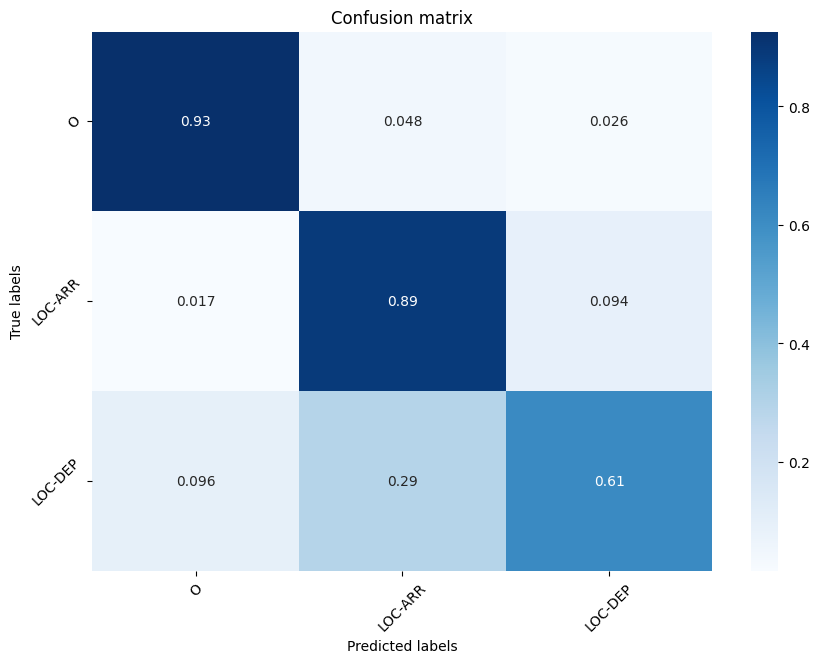

In [106]:
confusion_matrix(padded_labels, eval_predictions, unique_labels)

In [116]:
def predict(
    sentence: str,
    model: tf.keras.Model,
    vocab: list[str] = vocab,
    max_len: int = MAX_LEN,
):
    """
    Predict the labels for a given sentence.

    Parameters:
    sentence (str): The sentence to predict.
    model (tf.keras.Model): The trained model.
    vocab (list): The vocabulary.
    max_len (int): The maximum length of the sentence.

    Returns:
    list: The predicted labels.
    """
    processed_sentence = dp.process_sentence(
        sentence, stemming=True, return_tokens=True
    )

    unstemmed_sentence = dp.process_sentence(
        sentence, stemming=False, return_tokens=True
    )

    encoded_sentence = encode_and_pad_sentence(processed_sentence, vocab, max_len)

    prediction = model.predict(tf.convert_to_tensor([encoded_sentence]))

    for word, label in zip(
        unstemmed_sentence, tf.math.argmax(prediction, axis=-1)[0].numpy()
    ):
        print(f"{word}: {list(unique_labels.keys())[label]}")

    return prediction

In [120]:
test_sentence = "Je veux aller à Paris en train de Montpellier"

test_pred = predict(test_sentence, lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Je: O
veux: O
aller: O
Paris: LOC-ARR
train: O
Montpellier: LOC-DEP
